<a href="https://colab.research.google.com/github/LimaCondas/Machine_Learning_2021/blob/main/ML_IMDB_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利用卷积神经网络对 IMDB 数据进行文本分类

## 引入实验中所涉及到的包
数据集包、数据预处理包、网络模型包、网络各层结构所对应的包

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential 
from keras.layers import Dense,Dropout,Activation 
from keras.layers import Embedding 
from keras.layers import Conv1D,GlobalMaxPooling1D 
from keras.datasets import imdb
import matplotlib.pyplot as plt
import keras.metrics

##定义绘制性能曲线函数

In [2]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = {'batch':[], 'epoch':[]}
    self.accuracy = {'batch':[], 'epoch':[]}
    self.val_loss = {'batch':[], 'epoch':[]}
    self.val_acc = {'batch':[], 'epoch':[]}
  def on_batch_end(self, batch, logs={}):
    self.losses['batch'].append(logs.get('loss'))
    self.accuracy['batch'].append(logs.get('acc'))
    self.val_loss['batch'].append(logs.get('val_loss'))
    self.val_acc['batch'].append(logs.get('val_acc'))
  def on_epoch_end(self, batch, logs={}):
    self.losses['epoch'].append(logs.get('loss'))
    self.accuracy['epoch'].append(logs.get('acc'))
    self.val_loss['epoch'].append(logs.get('val_loss'))
    self.val_acc['epoch'].append(logs.get('val_acc'))
  def loss_plot(self, loss_type):
    iters = range(len(self.losses[loss_type]))
    plt.figure()
    # acc
    #plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
    # loss
    plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
    if loss_type == 'epoch':
      # val_acc
      #plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
      # val_loss
      plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
    plt.grid(True)
    plt.xlabel(loss_type)
    plt.ylabel('acc-loss')
    plt.legend(loc="upper right")
    plt.show()

##定义评价参数

In [3]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

## 设置网络结构中的一些常数
包含了两方面的常数
1. 数据处理过程中，词向量维度，词汇表长度等
2. 网络结构中参数

In [4]:
# 设置词汇表的长度，在数据预处理过程中，选择词汇字典中前max_features索引的词汇。 
max_features = 10000 
# 将每个句子填充或截断至maxlen长度 
maxlen = 400

# 设置词向量的维度 
embedding_dims = 50 
filters = 250 
kernel_size = 3

# 设置全连接层中，神经元的个数, 批处理量
batch_size = 16
hidden_dims = 500 
epochs = 10

## 加载数据与数据预处理

In [5]:
print("============ Loading data... ============") 
(x_train,y_train),(x_test,y_test) = imdb.load_data(num_words = max_features) 
print(len(x_train),"train sequences") 
print(len(x_test),"test sequences") 
print("pad sequences (samples*time)") 
# 填充每一条数据使所有的数据维度相同
x_train=sequence.pad_sequences(x_train,maxlen=maxlen) 
x_test=sequence.pad_sequences(x_test,maxlen=maxlen) 
print("x_train.shape:",x_train.shape) 
print("x_test.shape:",x_test.shape)

==== Loading data... ====
17473536/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
pad sequences (samples*time)
x_train.shape: (25000, 400)
x_test.shape: (25000, 400)


##建立模型

In [6]:
print("============ Building Model... ============") 
# 采用序列模型 
model=Sequential() 
# 添加词嵌入层作为神经网络的第一层
# 添加 Dropout 防止过拟合
model.add(Embedding(max_features,embedding_dims,input_length=maxlen)) 
model.add(Dropout(0.4)) 
model.add(Conv1D(filters,kernel_size,padding="valid",activation='relu',strides=1)) 
# 使用 Maxpooling 最大池化层
model.add(GlobalMaxPooling1D()) 
# 添加全连接层 
model.add(Dense(hidden_dims)) 
model.add(Dropout(0.4)) 
model.add(Activation('relu')) 
# 输出层
model.add(Dense(1)) 
model.add(Activation("sigmoid")) 
model.compile(loss="binary_crossentropy", optimizer='RMSprop', metrics = METRICS)
history_loss = LossHistory()
#创建一个实例 history 用于保存输出结果
history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test,y_test), callbacks=[history_loss])

============ Building Model... ============
Epoch 1/10
1563/1563 [==============================] - 80s 50ms/step - loss: 0.4408 - tp: 9880.0000 - fp: 2800.0000 - tn: 9700.0000 - fn: 2620.0000 - accuracy: 0.7832 - precision: 0.7792 - recall: 0.7904 - auc: 0.8750 - val_loss: 0.2941 - val_tp: 10872.0000 - val_fp: 1502.0000 - val_tn: 10998.0000 - val_fn: 1628.0000 - val_accuracy: 0.8748 - val_precision: 0.8786 - val_recall: 0.8698 - val_auc: 0.9476
Epoch 2/10
1563/1563 [==============================] - 77s 49ms/step - loss: 0.3035 - tp: 10978.0000 - fp: 1611.0000 - tn: 10889.0000 - fn: 1522.0000 - accuracy: 0.8747 - precision: 0.8720 - recall: 0.8782 - auc: 0.9445 - val_loss: 0.2838 - val_tp: 10399.0000 - val_fp: 852.0000 - val_tn: 11648.0000 - val_fn: 2101.0000 - val_accuracy: 0.8819 - val_precision: 0.9243 - val_recall: 0.8319 - val_auc: 0.9578
Epoch 3/10
1563/1563 [==============================] - 76s 49ms/step - loss: 0.2706 - tp: 11151.0000 - fp: 1408.0000 - tn: 11092.0000 - fn: 13

##画出相关结果图表

Test score: 0.2470541000366211
Test accuracy: 11234.0


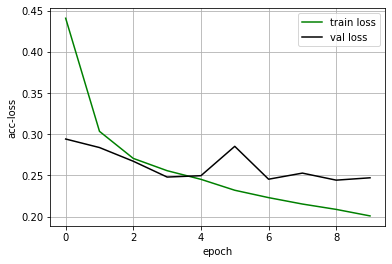

In [7]:
#模型评估
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
#绘制acc-loss曲线
history_loss.loss_plot('epoch')

## 参数评估

###定义损失曲线、AUC曲线、精确率曲线以及召回率曲线函数

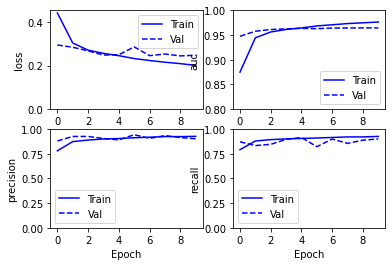

In [10]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='b', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(history)